In [2]:
# cell 1 - imports and helpers
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from collections import Counter
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except Exception:
    XGBOOST_AVAILABLE = False

# Optional imblearn (oversampling)
try:
    from imblearn.over_sampling import RandomOverSampler, SMOTE
    IMBLEARN_AVAILABLE = True
except Exception:
    IMBLEARN_AVAILABLE = False

# create result dirs
os.makedirs("model_result", exist_ok=True)
os.makedirs("results", exist_ok=True)

def show_df_info(df, n=5):
    print("shape:", df.shape)
    display(df.head(n))
    print("\n--- dtypes ---")
    print(df.dtypes)
    print("\n--- nulls (%) ---")
    print((df.isna().sum() / len(df) * 100).round(3))


In [3]:
# cell 2 - load and basic inspection
# adjust path if your file is under data/...
paths_try = [
    "data/spot_with_composite_signals_2023.csv",
    "data/spot_with_signals_2023.csv",
    "spot_with_composite_signals_2023.csv",
    "spot_with_signals_2023.csv"
]

for p in paths_try:
    if os.path.exists(p):
        path = p
        break
else:
    raise FileNotFoundError("spot file not found. Put it in data/ or current folder and retry.")

print("Loading:", path)
spot = pd.read_csv(path, parse_dates=["datetime"], low_memory=False)
show_df_info(spot, n=3)

# handle datetime tz if present -> normalize to tz-naive in Asia/Kolkata
try:
    if getattr(spot["datetime"].dt, "tz", None) is not None:
        # If tz-aware convert
        spot["datetime"] = spot["datetime"].dt.tz_convert("Asia/Kolkata")
        spot["datetime"] = spot["datetime"].dt.tz_localize(None)
except Exception:
    # safe fallback (some pandas versions)
    pass

# sort by datetime (time series)
spot = spot.sort_values("datetime").reset_index(drop=True)
print("Datetime range:", spot["datetime"].min(), "->", spot["datetime"].max())


Loading: data/spot_with_composite_signals_2023.csv
shape: (90882, 29)


,datetime,open,high,low,close,closest_expiry,ap,esa,d,ci,...,atr,bb_mid,bb_upper,bb_lower,stoch_k,stoch_d,ema_fast,ema_slow,composite_score,composite_signal
0,2023-01-02 09:20:00+05:30,18131.70,18150.15,18117.55,18141.35,2023-01-05,18125.43,18129.07,23.75,-10.22,...,NaN,NaN,NaN,NaN,NaN,NaN,18141.350000,18141.350000,0.00,Hold
1,2023-01-02 09:21:00+05:30,18142.20,18145.70,18131.40,18135.65,2023-01-05,18125.43,18129.07,23.75,-10.22,...,NaN,NaN,NaN,NaN,NaN,NaN,18140.083333,18140.831818,-0.25,Sell
2,2023-01-02 09:22:00+05:30,18133.25,18140.55,18120.65,18140.55,2023-01-05,18125.43,18129.07,23.75,-10.22,...,NaN,NaN,NaN,NaN,NaN,NaN,18140.187037,18140.806198,-0.25,Sell



--- dtypes ---
datetime            datetime64[ns, UTC+05:30]
open                                  float64
high                                  float64
low                                   float64
close                                 float64
closest_expiry                         object
ap                                    float64
esa                                   float64
d                                     float64
ci                                    float64
tci                                   float64
wt1                                   float64
wt2                                   float64
rsi                                   float64
cross                                 float64
signal                                 object
macd                                  float64
macd_signal                           float64
macd_hist                             float64
atr                                   float64
bb_mid                                float64
bb_upper          

In [4]:
# cell 3 - target distribution and basic checks
if "composite_signal" not in spot.columns:
    raise KeyError("column 'composite_signal' not found. Make sure you ran indicators+signal pipeline.")

print("Unique composite_signal values:")
print(spot["composite_signal"].value_counts(dropna=False))

# numeric mapping we will use: Sell -> 0, Hold -> 1, Buy -> 2
label_map = {"Sell": 0, "Hold": 1, "Buy": 2}
spot["target_raw"] = spot["composite_signal"].map({"Buy":1, "Hold":0, "Sell":-1})  # -1/0/1 for readability
spot["target"] = spot["target_raw"].map({-1:0, 0:1, 1:2})

print("\nMapped label counts (0=Sell,1=Hold,2=Buy):")
print(spot["target"].value_counts(), "\n")
display(spot.groupby("composite_signal")["datetime"].agg(["min","max","count"]))


Unique composite_signal values:
composite_signal
Hold    54602
Buy     18820
Sell    17460
Name: count, dtype: int64

Mapped label counts (0=Sell,1=Hold,2=Buy):
target
1    54602
2    18820
0    17460
Name: count, dtype: int64 



,min,max,count
composite_signal,,,
Buy,2023-01-02 09:43:00,2023-12-29 15:30:00,18820
Hold,2023-01-02 09:20:00,2023-12-29 15:19:00,54602
Sell,2023-01-02 09:21:00,2023-12-29 15:29:00,17460


In [4]:
%pip install imbalanced-learn


  Using cached imbalanced_learn-0.14.0-py3-none-any.whl.metadata (8.8 kB)
Using cached imbalanced_learn-0.14.0-py3-none-any.whl (239 kB)
Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd

# Load your spot data
df = pd.read_csv("data/spot_with_composite_signals_2023.csv", parse_dates=["datetime"])

print(df.head())
print(df.dtypes)
print(df.isna().mean() * 100)   # null %


                   datetime      open      high       low     close  \
0 2023-01-02 09:20:00+05:30  18131.70  18150.15  18117.55  18141.35   
1 2023-01-02 09:21:00+05:30  18142.20  18145.70  18131.40  18135.65   
2 2023-01-02 09:22:00+05:30  18133.25  18140.55  18120.65  18140.55   
3 2023-01-02 09:23:00+05:30  18139.40  18139.40  18120.15  18130.75   
4 2023-01-02 09:24:00+05:30  18130.30  18133.55  18113.05  18113.10   

  closest_expiry        ap       esa      d     ci  ...  atr  bb_mid  \
0     2023-01-05  18125.43  18129.07  23.75 -10.22  ...  NaN     NaN   
1     2023-01-05  18125.43  18129.07  23.75 -10.22  ...  NaN     NaN   
2     2023-01-05  18125.43  18129.07  23.75 -10.22  ...  NaN     NaN   
3     2023-01-05  18125.43  18129.07  23.75 -10.22  ...  NaN     NaN   
4     2023-01-05  18125.43  18129.07  23.75 -10.22  ...  NaN     NaN   

   bb_upper  bb_lower  stoch_k stoch_d      ema_fast      ema_slow  \
0       NaN       NaN      NaN     NaN  18141.350000  18141.350000   


In [7]:
# Drop useless columns
drop_cols = ["closest_expiry", "cross", "signal"]
df = df.drop(columns=[c for c in drop_cols if c in df.columns])


In [8]:
# Forward fill, then median fill
df = df.ffill().bfill()
df = df.fillna(df.median(numeric_only=True))


In [10]:
# Map signals to numeric
mapping = {"Sell": 0, "Hold": 1, "Buy": 2}
df["target"] = df["composite_signal"].map(mapping)

print(df["target"].value_counts())


target
1    54602
2    18820
0    17460
Name: count, dtype: int64


In [11]:
# Returns + volatility
df["returns"] = df["close"].pct_change().fillna(0)
df["volatility"] = df["returns"].rolling(20).std().fillna(0)

# Lag features
for lag in [1, 2, 5]:
    df[f"close_lag{lag}"] = df["close"].shift(lag).fillna(df["close"])
    df[f"rsi_lag{lag}"]   = df["rsi"].shift(lag).fillna(df["rsi"])


In [12]:
from sklearn.model_selection import train_test_split

features = [
    "open","high","low","close","macd","macd_signal","macd_hist",
    "rsi","atr","bb_mid","bb_upper","bb_lower","stoch_k","stoch_d",
    "ema_fast","ema_slow","returns","volatility",
    "close_lag1","close_lag2","close_lag5",
    "rsi_lag1","rsi_lag2","rsi_lag5"
]

X = df[features]
y = df["target"]

# Time-based split: first 80% train, last 20% test
split = int(len(df)*0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)



In [14]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000, class_weight="balanced")
log_reg.fit(X_train_scaled, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


NaNs after cleaning: 0
train/val/test sizes: 63617 13632 13633
Train label counts: Counter({np.int64(1): 38262, np.int64(2): 13173, np.int64(0): 12182})

🔹 Training LogisticRegression...
✅ LogisticRegression Validation Accuracy: 0.4862
              precision    recall  f1-score   support

           0     0.4122    0.8112    0.5466      2685
           1     0.7157    0.2796    0.4021      8212
           2     0.4191    0.7876    0.5470      2735

    accuracy                         0.4862     13632
   macro avg     0.5157    0.6261    0.4986     13632
weighted avg     0.5964    0.4862    0.4596     13632


🔹 Training RandomForest...
✅ RandomForest Validation Accuracy: 0.9228
              precision    recall  f1-score   support

           0     0.8635    0.9497    0.9046      2685
           1     0.9671    0.9061    0.9356      8212
           2     0.8670    0.9463    0.9049      2735

    accuracy                         0.9228     13632
   macro avg     0.8992    0.9340    0.9

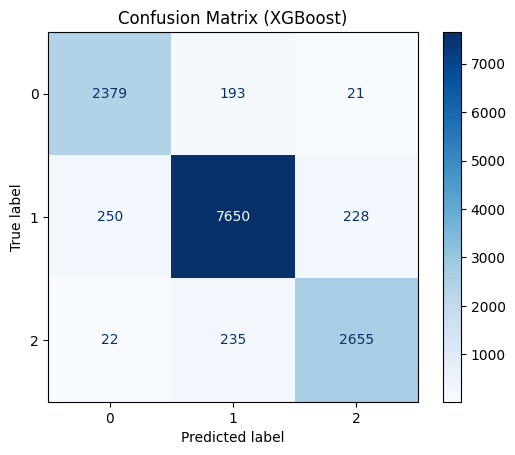

💾 Best model bundle saved to model_result/best_model_bundle.pkl


In [20]:
# cell 11 - Full training & evaluation pipeline (with NaN handling)

import os, joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
from collections import Counter

# --- 1. Ensure spot data is sorted by datetime ---
spot = spot.sort_values("datetime").reset_index(drop=True)

# --- 2. Define feature set ---
features = [
    "open","high","low","close",
    "macd","macd_signal","macd_hist",
    "rsi","atr","bb_mid","bb_upper","bb_lower",
    "stoch_k","stoch_d","ema_fast","ema_slow",
    "returns","volatility_20",
    "close_lag1","close_lag2","close_lag5",
    "rsi_lag1","rsi_lag2","rsi_lag5"
]
features = [f for f in features if f in spot.columns]

# --- 3. Fill missing values (safely) ---
spot[features] = spot[features].ffill().bfill()
spot[features] = spot[features].fillna(spot[features].median())

# double-check no NaNs remain
print("NaNs after cleaning:", spot[features].isna().sum().sum())

# --- 4. Time-based split ---
N = len(spot)
train_frac, val_frac = 0.70, 0.15
train_end = int(N * train_frac)
val_end   = int(N * (train_frac + val_frac))

train_df = spot.iloc[:train_end].copy()
val_df   = spot.iloc[train_end:val_end].copy()
test_df  = spot.iloc[val_end:].copy()

print("train/val/test sizes:", len(train_df), len(val_df), len(test_df))

# --- 5. Scale features (fit on TRAIN only) ---
X_train = train_df[features].copy()
X_val   = val_df[features].copy()
X_test  = test_df[features].copy()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

y_train = train_df["target"].values
y_val   = val_df["target"].values
y_test  = test_df["target"].values

print("Train label counts:", Counter(y_train))

# --- 6. Models ---
models = {
    "LogisticRegression": LogisticRegression(max_iter=200, class_weight="balanced", random_state=42),
    "RandomForest": RandomForestClassifier(
        n_estimators=300, max_depth=10, class_weight="balanced_subsample", random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=300, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8,
        objective="multi:softmax", num_class=3,
        eval_metric="mlogloss", random_state=42
    )
}

results = {}
best_model, best_acc, best_name = None, 0, None

# --- 7. Train & validate ---
for name, clf in models.items():
    print(f"\n🔹 Training {name}...")
    clf.fit(X_train_scaled, y_train)

    y_val_pred = clf.predict(X_val_scaled)
    acc = accuracy_score(y_val, y_val_pred)
    print(f"✅ {name} Validation Accuracy: {acc:.4f}")
    print(classification_report(y_val, y_val_pred, digits=4))

    results[name] = acc
    if acc > best_acc:
        best_acc, best_model, best_name = acc, clf, name

print("\n📊 Validation Accuracies:", results)
print(f"🏆 Best model: {best_name} with acc={best_acc:.4f}")

# --- 8. Final Test Evaluation ---
y_test_pred = best_model.predict(X_test_scaled)
print("\n=== Test Set Evaluation (Best Model) ===")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred, digits=4))

# --- 9. Confusion Matrix ---
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, cmap="Blues")
plt.title(f"Confusion Matrix ({best_name})")
plt.show()

# --- 10. Save bundle for backtest ---
os.makedirs("model_result", exist_ok=True)
bundle = {"model": best_model, "scaler": scaler, "features": features}
joblib.dump(bundle, "model_result/best_model_bundle.pkl")
print("💾 Best model bundle saved to model_result/best_model_bundle.pkl")
